# Item 2 Item recommendations with RePlay

The task statement assumes the recommendation of a list of objects similar to this object. These recommendations are popular for e-commerce platforms, music streaming services, online cinemas, etc. Such solutions can be used wherever it will be useful for the user to learn about such objects.

RePlay models representing functionality for searching for similar objects:

* `Word2VecRec` - Trains word2vec model where items ar treated as words and users as sentences. <br><br>
* `ItemKNN` - k-nearest neighbors method with a generalized cosine similarity between items. <br><br>
* `SLIM` - 
    Treats recommendation as a multivariate regression problem, predicting each item column S[i] given all other item columns while encouraging for the regression weights to be sparse. We use the weights given to each of the other items directly as ranking scores.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from pyspark.sql import functions as sf
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import (
    IntegerType,
    StructField,
    StructType,
)

from replay.experimental.preprocessing.data_preparator import DataPreparator, Indexer
from replay.models import Word2VecRec, ItemKNN, SLIM
from replay.utils.session_handler import State
from replay.splitters import TimeSplitter
from replay.data import Dataset, FeatureHint, FeatureInfo, FeatureSchema, FeatureType
from replay.metrics import Precision, HitRate, Recall, Experiment
from replay.preprocessing.filters import MinCountFilter, LowRatingFilter
from replay.utils.spark_utils import get_log_info

In [2]:
spark = State().session
spark.sparkContext.setLogLevel('ERROR')
spark

24/03/03 19:24:05 WARN Utils: Your hostname, LinuxML resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)

24/03/03 19:24:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties

Setting default log level to "WARN".

To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).

24/03/03 19:24:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable

24/03/03 19:24:09 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


### Dataset

[eCommerce events history in electronics store](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store)

The dataset includes the user's interaction(view, cart, purchase) with products in the online store for 3 months.
To train and evaluate models, we use the "view" interactions as implicit feedback.

In [4]:
data = pd.read_csv("events.csv", parse_dates=["event_time"])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 885129 entries, 0 to 885128

Data columns (total 9 columns):

 #   Column         Non-Null Count   Dtype              

---  ------         --------------   -----              

 0   event_time     885129 non-null  datetime64[ns, UTC]

 1   event_type     885129 non-null  object             

 2   product_id     885129 non-null  int64              

 3   category_id    885129 non-null  int64              

 4   category_code  648910 non-null  object             

 5   brand          672765 non-null  object             

 6   price          885129 non-null  float64            

 7   user_id        885129 non-null  int64              

 8   user_session   884964 non-null  object             

dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)

memory usage: 60.8+ MB


In [6]:
data = data[data["event_type"] == "view"]

Number of unique items.

In [7]:
data["product_id"].unique().shape[0]

53452

Number of unique users.

In [8]:
data["user_id"].unique().shape[0]

406863

Number of unique sessions.

In [9]:
data["user_session"].unique().shape[0]

488361

Let's look at the number of interactions for each day presented in the dataset.

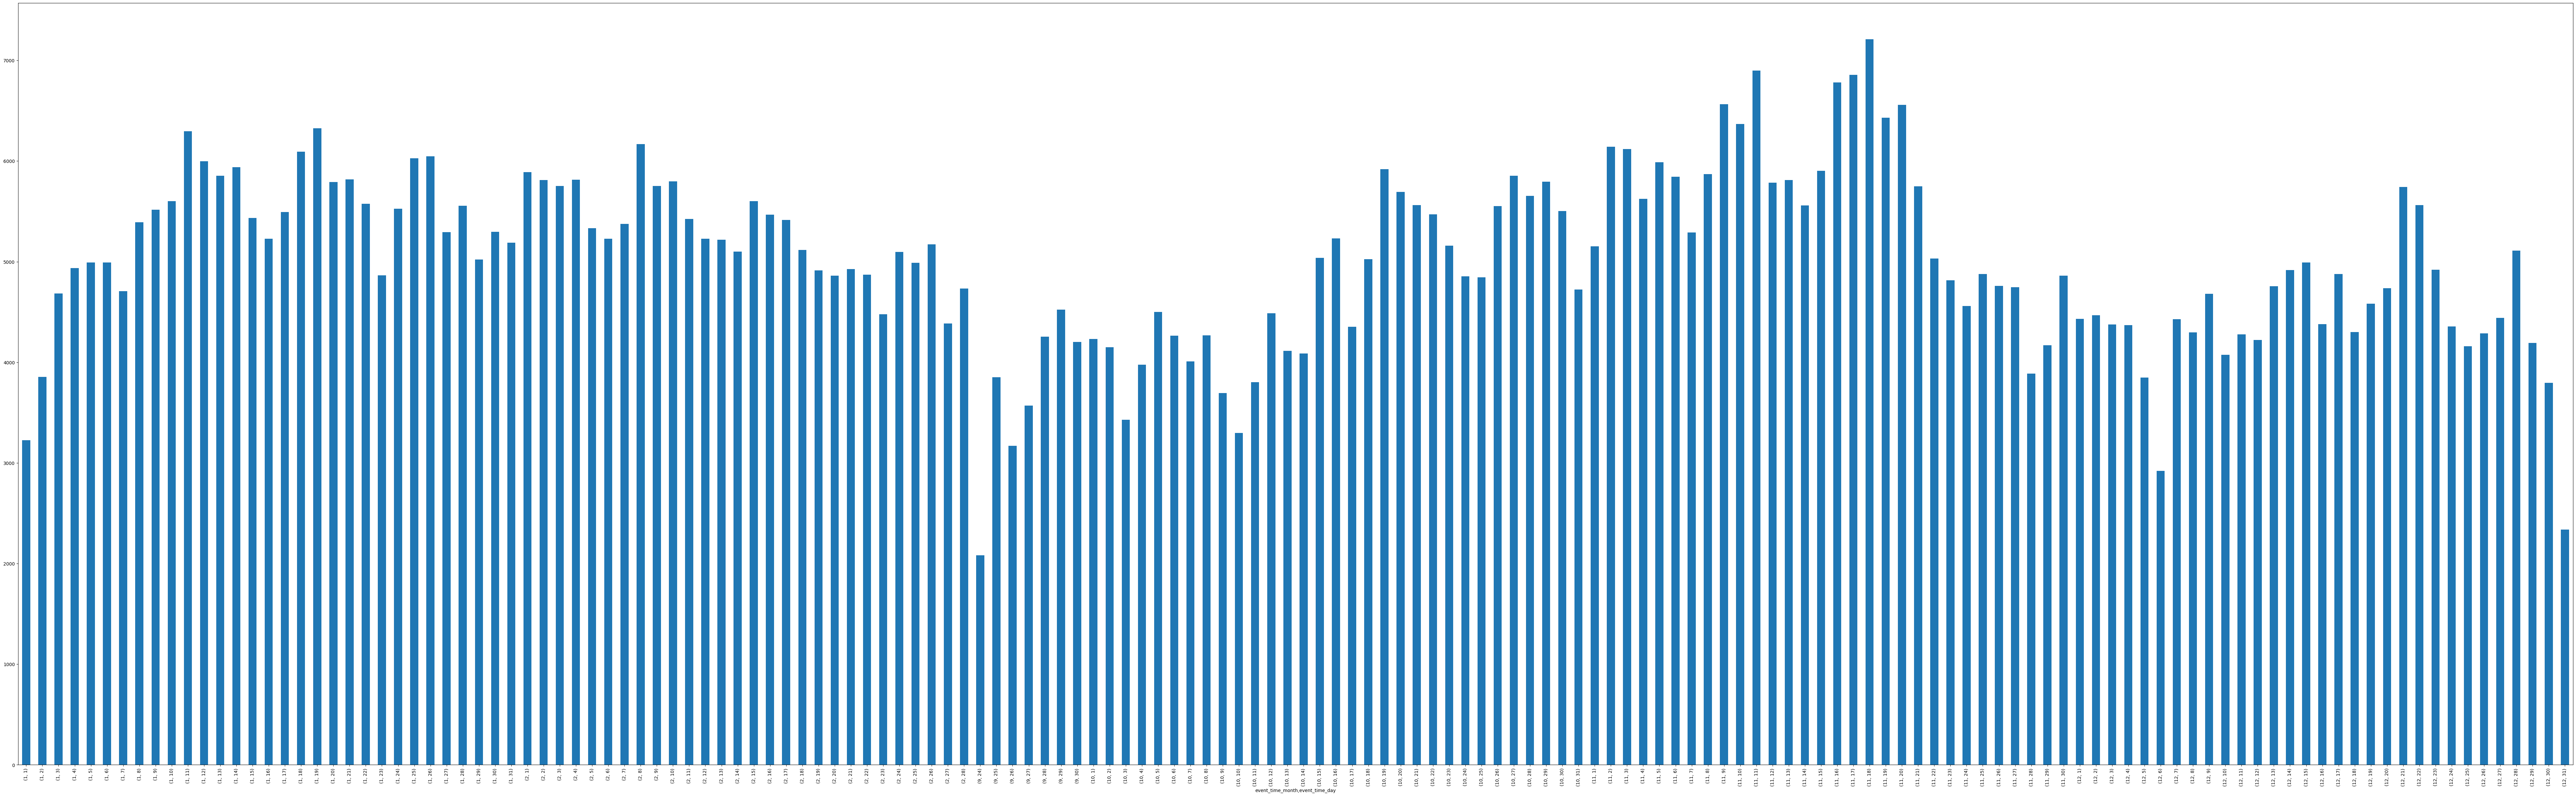

In [10]:
data["event_time_month"] = data["event_time"].dt.month
data["event_time_day"] = data["event_time"].dt.day

res = data.groupby(["event_time_month", "event_time_day"]).count()["event_time"]
res.plot(kind="bar", figsize=(100, 30))
None

### Data preparation

Using RePlay tools, we prepare data for use in models.

In [11]:
preparator = DataPreparator()

`DataPreparator()` add a `relevance` column equal to one

In [12]:
log = preparator.transform(data=data,
                  columns_mapping={
                      "user_id": "user_id",
                      "item_id":  "product_id",
                      "timestamp": "event_time"
                  })

03-Mar-24 19:25:38, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.

/home/duny/replay/replay/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:471: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.

  arrow_data = [[(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]

03-Mar-24 19:25:45, replay, INFO: Columns ['relevance'] are absent, but may be required for models training. Add them with DataPreparator().generate_absent_log_cols


Let's look at the basic statistics using the `get_log_info()` function.

In [13]:
get_log_info(log, user_col='user_id', item_col='item_id')

'total lines: 793748, total users: 406863, total items: 53452'

For the correct and stable operation of the models, we need to index `item_id`, `user_id`

In [14]:
indexer = Indexer(user_col='user_id', item_col='item_id')

In [15]:
indexer.fit(users=log.select('user_id'),
           items=log.select('item_id'))

In [16]:
log_replay = indexer.transform(df=log)

We want to correctly predict similar items in the future. To split we use `TimeSplitter()`

In [17]:
date_splitter = TimeSplitter(
    time_threshold=0.2,
    drop_cold_items=True,
    query_column = "user_idx",
    item_column = "item_idx"
)

In [18]:
train, test = date_splitter.split(log_replay)

### Make Ground truth

The data is presented in the format of interaction between the user and the product, in order to evaluate the item-item recommendations, we need to create a list of similar items for each item.

To collect data, we are interested in sessions in which there are at least 2 interactions.

In [19]:
test = MinCountFilter(num_entries=2, groupby_column='user_session').transform(test)
get_log_info(test, user_col='user_idx', item_col='item_idx')

'total lines: 86141, total users: 21139, total items: 13083'

In [20]:
def make_ground_truth_seq(pandas_df):
    list_items = pandas_df["item_idx"].unique()
    pairs = pd.concat([pandas_df["item_idx"], pandas_df["item_idx"].shift(1, fill_value=0)], axis=1)[1:]
    all_pairs = pd.concat([pairs.iloc[:, [1,0]], pairs.iloc[:, [0,1]]])
    all_pairs.columns = ["item_idx", "neighbour_item_idx"]

    return all_pairs

In [21]:
def make_ground_truth_all_to_all(pandas_df):
    list_items = pandas_df["item_idx"].unique()
    sim_itms = []
    for i in list_items:
        for j in list_items:
            if i != j:
                sim_itms.append([i, j])

    return pd.DataFrame(sim_itms, columns=["item_idx", "neighbour_item_idx"])

In [22]:
ground_truth_seq = test.groupby("user_session").applyInPandas(make_ground_truth_seq, StructType(
    [
        StructField("item_idx", IntegerType()),
        StructField("neighbour_item_idx", IntegerType()),
    ]
))

In [23]:
ground_truth_all_to_all = test.groupby("user_session").applyInPandas(make_ground_truth_all_to_all, StructType(
    [
        StructField("item_idx", IntegerType()),
        StructField("neighbour_item_idx", IntegerType()),
    ]
))

Different users can view the same products. Remove duplicates.

In [24]:
ground_truth_all_to_all = ground_truth_all_to_all.select("item_idx", "neighbour_item_idx").distinct()
ground_truth_seq = ground_truth_seq.select("item_idx", "neighbour_item_idx").distinct()

gt_touple = [
    (ground_truth_all_to_all, "all_to_all"), 
    (ground_truth_seq, "seq")
]

### Check ground truth: all to all method

In [25]:
ground_truth_all_to_all.cache()
ground_truth_all_to_all.count()

155496

#### Check unique items

In [26]:
ground_truth_all_to_all.groupBy("item_idx").count().count()

11276

In [27]:
count_all_pd = ground_truth_all_to_all.groupBy("item_idx").count().toPandas()

#### Distribution of the number of similar items

num items: 11276


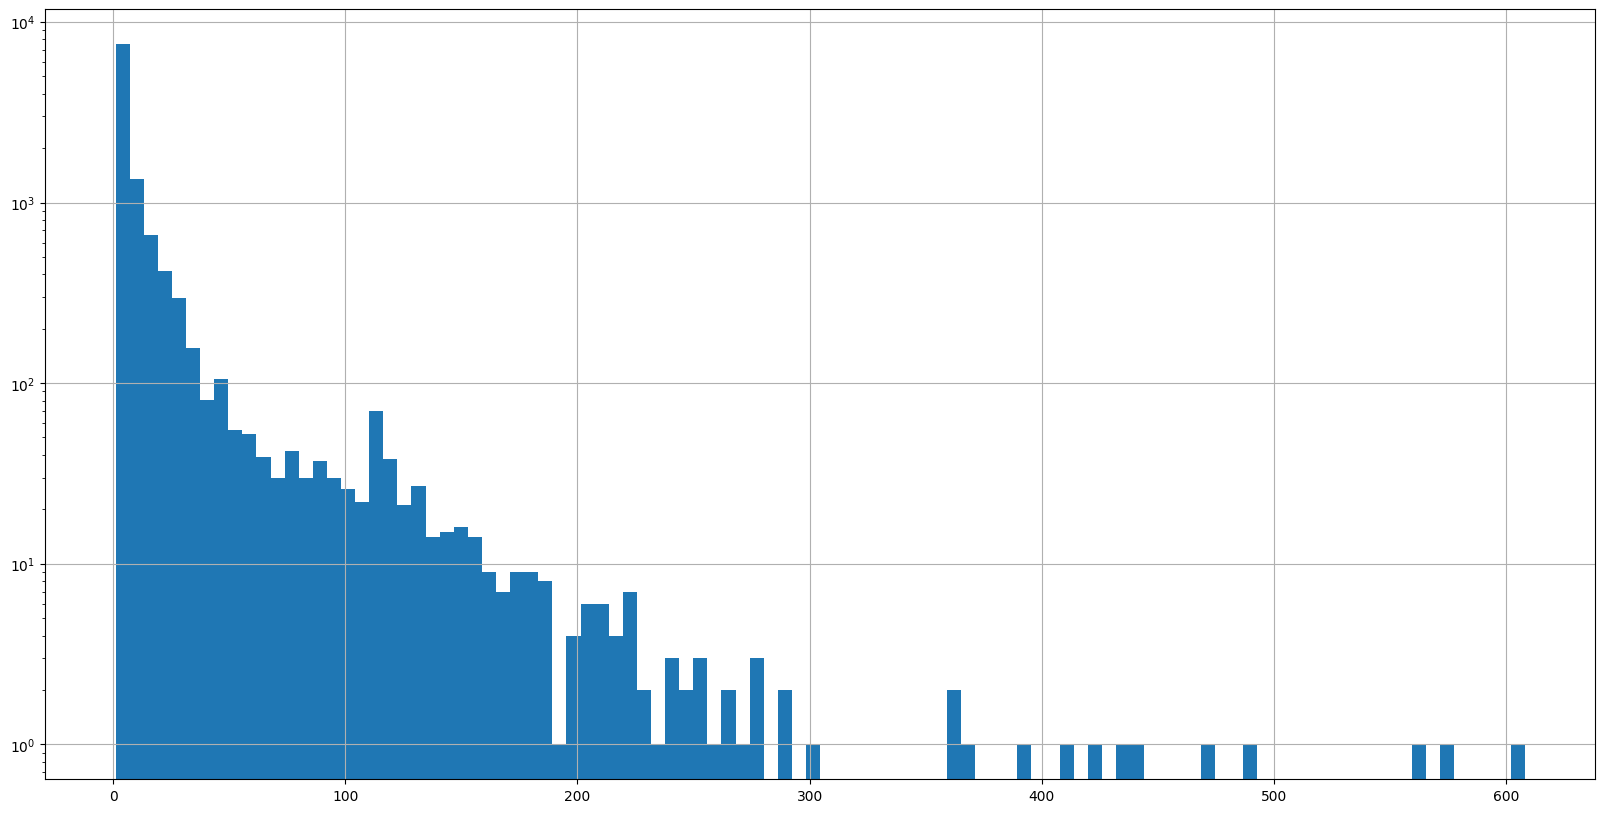

In [28]:
count_all_pd["count"].hist(bins=100, figsize=(20, 10), log=True)
print("num items:", count_all_pd["count"].shape[0])

Items having more than 10 similar.

0.2577155019510465 %  of all items


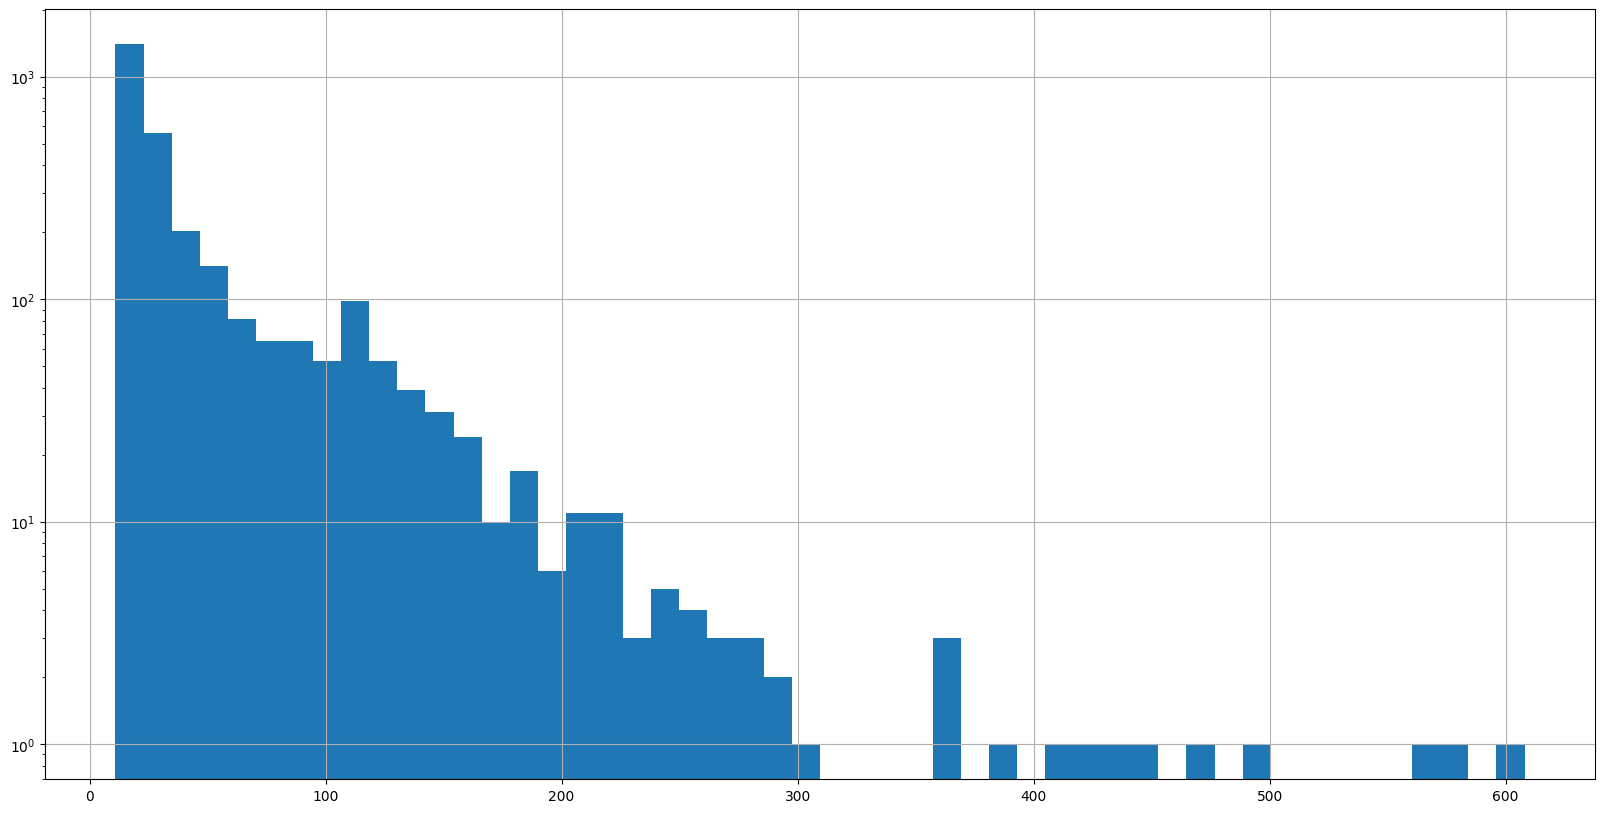

In [29]:
count_all_pd[(count_all_pd["count"] > 10)]["count"].hist(bins=50, figsize=(20, 10), log=True)
print(count_all_pd[count_all_pd["count"] > 10]["count"].shape[0] / count_all_pd["count"].shape[0], "%  of all items")

In [30]:
ground_truth_all_to_all_min10 = MinCountFilter(10, "item_idx").transform(ground_truth_all_to_all)
gt_touple.append((ground_truth_all_to_all_min10, "all_to_all min 10"))

### Check ground truth: sequence method

In [31]:
ground_truth_seq.cache()
ground_truth_seq.count()

48022

In [32]:
ground_truth_seq.groupBy("item_idx").count().count()

13083

In [33]:
count_seq_pd = ground_truth_seq.groupBy("item_idx").count().toPandas()

#### Distribution of the number of similar items

num items: 13083


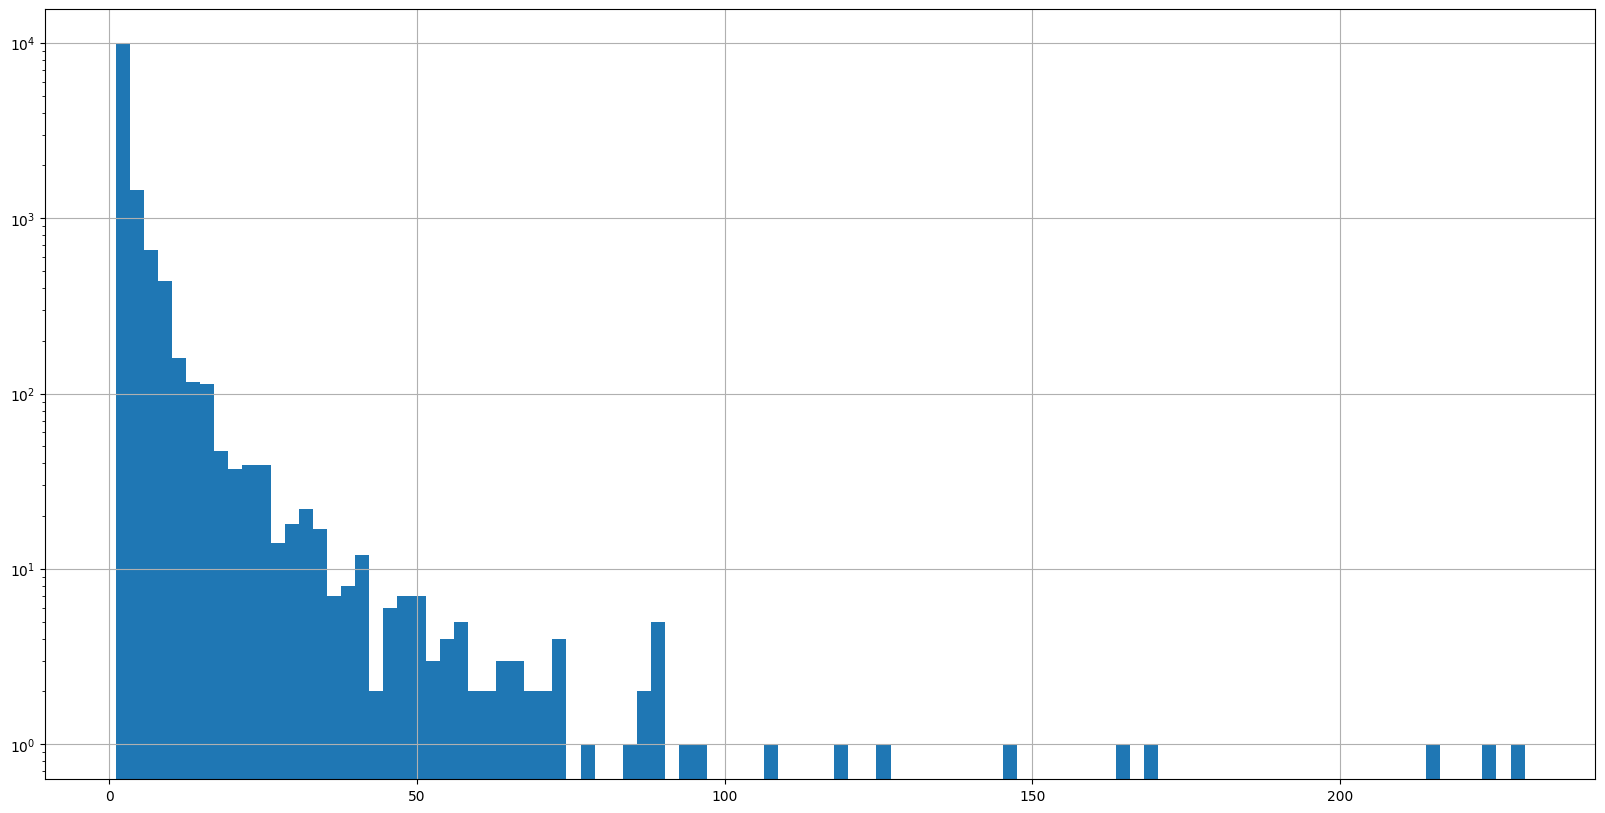

In [34]:
count_seq_pd["count"].hist(bins=100, figsize=(20, 10), log=True)
print("num items:", count_seq_pd["count"].shape[0])

Items having more than 10 similar.

0.05510968432316747 %  of all items


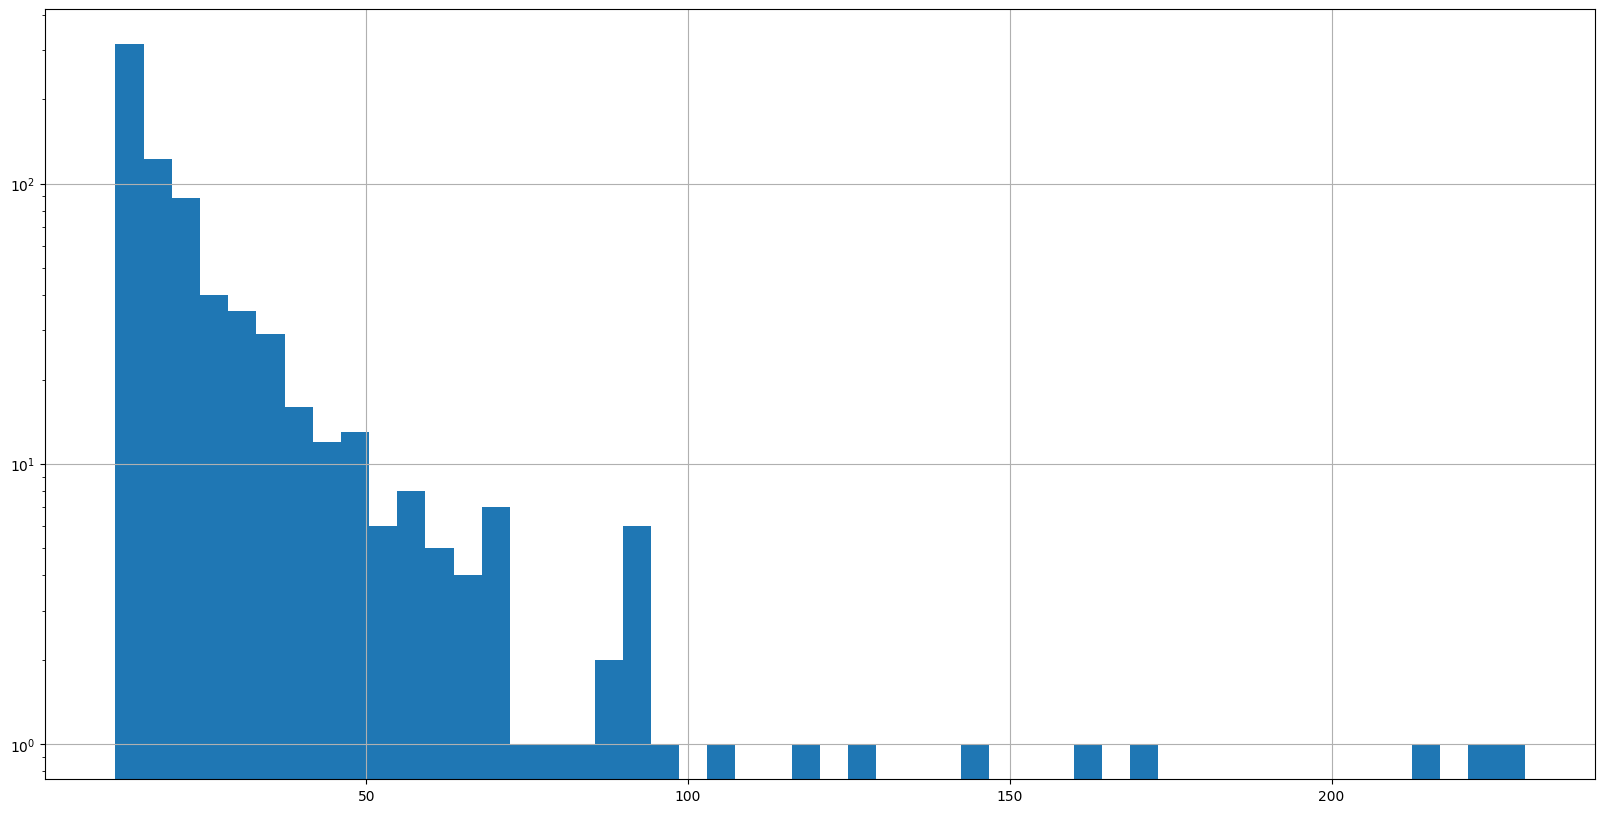

In [35]:
count_seq_pd[(count_seq_pd["count"] > 10)]["count"].hist(bins=50, figsize=(20, 10), log=True)
print(count_seq_pd[count_seq_pd["count"] > 10]["count"].shape[0] / count_seq_pd["count"].shape[0], "%  of all items")

In [36]:
ground_truth_seq_min10 = MinCountFilter(10, "item_idx").transform(ground_truth_seq)
gt_touple.append((ground_truth_seq_min10, "seq min 10"))

### Training and evaluation of models

Evaluate the models and calculate metrics(Accuracy@N, Review@N, HitRate@N) with the Experiment class.

In [37]:
def evaluate(models, ground_truth_touple, K=10):
    exprms_names = []
    
    for gt, name in ground_truth_touple:
        
        rnm_gt = (
            gt
            .withColumnRenamed("item_idx", "user_idx")
            .withColumnRenamed("neighbour_item_idx", "item_idx")
        )
        
        exp = Experiment(
            [Precision(K), Recall(K), HitRate([1, K])],
            rnm_gt,
            query_column="user_idx", item_column="item_idx", rating_column="relevance"
        )

        for model, sim_col in models:
            
            preds = model.get_nearest_items(gt.select("item_idx").distinct(), K)
            
            rnm_preds = (
                preds
                .withColumnRenamed("item_idx", "user_idx")
                .withColumnRenamed("neighbour_item_idx", "item_idx")
                .withColumnRenamed(sim_col, "relevance")
            )
            
            exp.add_result(str(model), rnm_preds)
 
        print(name, exp.results, sep='\n')

The same users could view the same products in different sessions. Remove duplicates.

In [38]:
train_knn = train.select("user_idx", "item_idx", "relevance").distinct()

In [39]:
model_knn = ItemKNN()

In [40]:
total_user_count = train_knn.select("user_idx").distinct().count()
total_item_count = train_knn.select("item_idx").distinct().count()
print(total_user_count, total_item_count)

331153 50207


In [41]:
feature_schema = FeatureSchema(
    [
        FeatureInfo(
            column="user_idx",
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.QUERY_ID,
            cardinality=total_user_count,
        ),
        FeatureInfo(
            column="item_idx",
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.ITEM_ID,
            cardinality=total_item_count,
        ),
        FeatureInfo(
            column="relevance",
            feature_type=FeatureType.NUMERICAL,
            feature_hint=FeatureHint.RATING,
        )
    ]
)

In [42]:
train_dataset = Dataset(
    feature_schema=feature_schema,
    interactions=train_knn,
)

In [43]:
model_knn.fit(train_dataset)

In [44]:
train_w2v = train.select("user_idx", "item_idx", "relevance", "timestamp").distinct()

In [45]:
feature_schema = FeatureSchema(
    [
        FeatureInfo(
            column="user_idx",
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.QUERY_ID,
            cardinality=total_user_count,
        ),
        FeatureInfo(
            column="item_idx",
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.ITEM_ID,
            cardinality=total_item_count,
        ),
        FeatureInfo(
            column="relevance",
            feature_type=FeatureType.NUMERICAL,
            feature_hint=FeatureHint.RATING,
        ),
        FeatureInfo(
            column="timestamp",
            feature_type=FeatureType.NUMERICAL,
            feature_hint=FeatureHint.TIMESTAMP,
        ),
    ]
)

In [46]:
train_dataset_w2 = Dataset(
    feature_schema=feature_schema,
    interactions=train_w2v,
)

In [47]:
model_w2v = Word2VecRec()

In [48]:
model_w2v.fit(train_dataset_w2)

/home/duny/replay/replay/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.

  warnings.warn(


Evaluate with different ground_truth

In [ ]:
evaluate([(model_knn, "similarity"), (model_w2v, "cosine_similarity")], gt_touple)

all_to_all

             Precision@10  Recall@10  HitRate@1  HitRate@10

ItemKNN          0.111715   0.198615   0.188453    0.491220

Word2VecRec      0.035775   0.027236   0.068553    0.124867


seq

             Precision@10  Recall@10  HitRate@1  HitRate@10

ItemKNN           0.05420   0.155630   0.109302    0.321792

Word2VecRec       0.01849   0.023783   0.040740    0.085225


all_to_all min 10

             Precision@10  Recall@10  HitRate@1  HitRate@10

ItemKNN           0.224952   0.087326   0.314050    0.675461

Word2VecRec       0.107565   0.025584   0.178322    0.285124


seq min 10

             Precision@10  Recall@10  HitRate@1  HitRate@10

ItemKNN           0.299078   0.152935   0.493088    0.831797

Word2VecRec       0.223848   0.098326   0.404378    0.618664
